Based on 
https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/equatorial_pacific/Equatorial_Pacific.ipynb
but also includes `01deg_jra55v13_ryf8485_spinup7` and `01deg_jra55v13_ryf9091`.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as cm

from dask.distributed import Client


import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata

print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
exptdata.exptdict['spinup7'] = \
              {'model': 'access-om2-01',
               'expt': '01deg_jra55v13_ryf8485_spinup7',
               'desc': 'ACCESS-OM2-01 spinup 7',
               'n_files': None,
#                'time_units': 'days since 0001-01-01',
               'time_units': 'days since 1988-01-01', # so .sel(time=slice(pd.datetime(1998,1,1),None)) removes first 10 years
               'offset': None,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf8485_spinup7'}

In [3]:
exptdata.exptdict['01deg_jra55v13_ryf9091'] = \
              {'model': 'access-om2-01',
               'expt': '01deg_jra55v13_ryf9091/',
               'desc': 'ACCESS-OM2-01 RYF 1990-91',
               'n_files': None,
#                'time_units': 'days since 0001-01-01',
               'time_units': 'days since 1988-01-01', # so .sel(time=slice(pd.datetime(1998,1,1),None)) removes first 10 years
               'offset': None,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091/'}

In [4]:
# for testing
# del exptdata.exptdict['1deg']
# del exptdata.exptdict['025deg']
# del exptdata.exptdict['01deg']

In [5]:
exptdata.exptdict

OrderedDict([('1deg',
              {'model': 'access-om2',
               'expt': '1deg_jra55v13_iaf_spinup1_B1',
               'desc': 'ACCESS-OM2',
               'n_files': -12,
               'time_units': 'days since 1718-01-01',
               'offset': -87658,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1'}),
             ('025deg',
              {'model': 'access-om2-025',
               'expt': '025deg_jra55v13_iaf_gmredi6',
               'desc': 'ACCESS-OM2-025',
               'n_files': -34,
               'time_units': 'days since 1718-01-01',
               'offset': -87658,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6'}),
             ('01deg',
              {'model': 'access-om2-01',
               'expt': '01deg_jra55v13_iaf',
               'desc': 'ACCESS-OM2-01',
               'n_files': None,
               'time_units': 'days since 0001-01-01',
               'offset'

In [6]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [7]:
tstart = pd.datetime(1998,1,1)  # must be 1 Jan so we don't average ove rpartial years
# tend = None # unused

In [8]:
def find_temp(ekey):
    e = exptdata.exptdict[ekey]    
    temp = cc.get_nc_variable(e['expt'], 'ocean.nc', 'temp',
                          chunks={'st_ocean': None}, n=e['n_files'],
                          time_units = e['time_units'], offset=e['offset'], use_cache=False)
    lastyear = temp.time[-1].values.astype('datetime64[Y]') # ensure we stop at Jan 1
    upper_temp_eq = temp.sel(st_ocean=slice(0,300)).sel(yt_ocean=0., method='nearest')\
                        .sel(xt_ocean=slice(-217,-95)).sel(time=slice(tstart,lastyear))\
                        .mean('time').load() - 273.15
    upper_temp_140w = temp.sel(st_ocean=slice(0,300)).sel(yt_ocean=slice(-8,10))\
                        .sel(xt_ocean=-140.,method='nearest').sel(time=slice(tstart,lastyear))\
                        .mean('time').load() - 273.15
    return upper_temp_eq, upper_temp_140w


def find_u(ekey):
    e = exptdata.exptdict[ekey]    
    u = cc.get_nc_variable(e['expt'], 'ocean.nc', 'u',
                          chunks={'st_ocean': None}, n=e['n_files'],
                          time_units = e['time_units'], offset=e['offset'], use_cache=False)
    lastyear = u.time[-1].values.astype('datetime64[Y]') # ensure we stop at Jan 1
    upper_u_eq = u.sel(st_ocean=slice(0,300)).sel(yu_ocean=0., method='nearest')\
                        .sel(xu_ocean=slice(-217,-95)).sel(time=slice(tstart,lastyear))\
                        .mean('time').load()*100
    upper_u_140w = u.sel(st_ocean=slice(0,300)).sel(yu_ocean=slice(-8,10))\
                        .sel(xu_ocean=-140.,method='nearest').sel(time=slice(tstart,lastyear))\
                        .mean('time').load()*100
    return upper_u_eq, upper_u_140w

In [9]:
lat = 0
lon = -140

In [10]:
for ekey in exptdata.exptdict.keys():
    e = exptdata.exptdict[ekey]
    temp = cc.get_nc_variable(e['expt'], 'ocean.nc', 'temp',
                          chunks={'st_ocean': None}, n=e['n_files'],
                          time_units = e['time_units'], offset=e['offset'], use_cache=False)
    lastyear = temp.time[-1].values.astype('datetime64[Y]') # ensure we stop at Jan 1
    e['yearrange'] = str(tstart.year)+'-'+str(lastyear-1)
    e['temp_profile'] = temp.sel(st_ocean=slice(0,300)).sel(yt_ocean=lat, method='nearest')\
                            .sel(xt_ocean=lon,method='nearest').sel(time=slice(tstart,lastyear))\
                            .mean('time').load() - 273.15

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

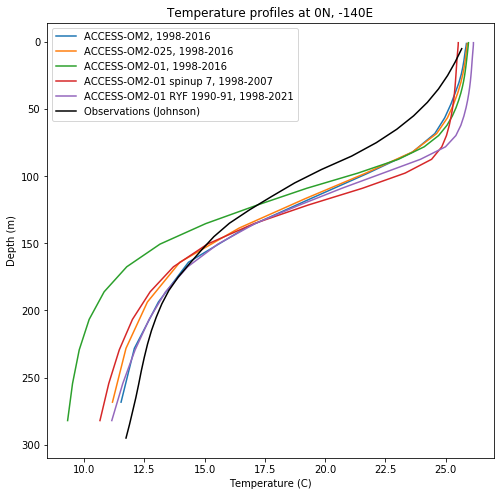

In [11]:
fig = plt.figure(figsize=(8,8))
for ekey in exptdata.exptdict.keys():
    e = exptdata.exptdict[ekey]
    tp = e['temp_profile']
    plt.plot(tp.values, tp.st_ocean.values, label=e['desc']+', '+e['yearrange'])
obs_temp = xr.open_dataset('/g/data1/v45/fw4078/obs-data/meanfit_m.cdf')['POTEMPM']
otp = obs_temp.sel(ZDEP1_50=slice(0,300)).sel(XLON=lon+360, method='nearest').sel(YLAT11_101=lat, method='nearest')
plt.plot(otp.values, otp.ZDEP1_50.values, label='Observations (Johnson)', color='k')

plt.gca().invert_yaxis()
plt.xlabel('Temperature (C)')
plt.ylabel('Depth (m)')
plt.title('Temperature profiles at '+str(lat)+'N, '+str(lon)+'E')
plt.legend()
savefigure('temp_profiles_'+str(lat)+'N_'+str(lon)+'E')

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer us

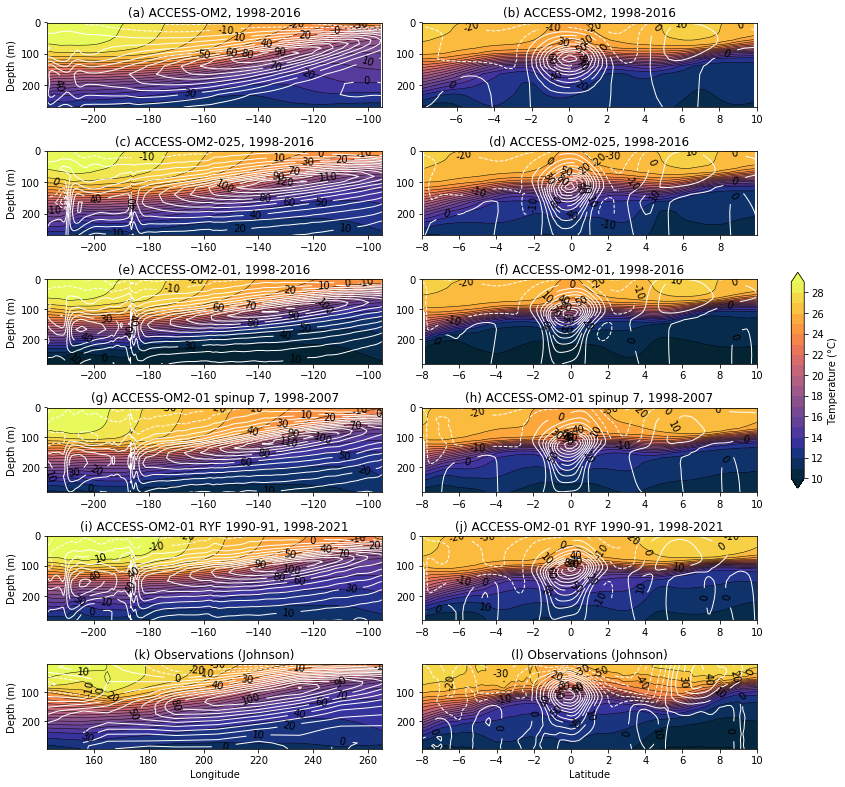

In [14]:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

# labels=['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ']

fig = plt.figure(figsize=(12,12))
for i, ekey in enumerate(exptdata.exptdict.keys()):
    e = exptdata.exptdict[ekey]
    upper_temp_eq, upper_temp_140w = find_temp(ekey)
    upper_u_eq, upper_u_140w = find_u(ekey)

    plt.subplot(1+len(exptdata.exptdict),2,2*i+1)
    p1=upper_temp_eq.plot.contourf(cmap=cm.cm.thermal, 
                                   levels=clevelsT,
                                   add_colorbar=False, extend='both')
    upper_temp_eq.plot.contour(colors='k', levels=clevelsT,
                                   add_colorbar=False,linewidths=0.5)
#    p2=upper_u_eq.plot.contour(colors='w',levels=clevelsU,linewidths=1)
    xv, yv = np.meshgrid(upper_u_eq.xu_ocean,upper_u_eq.st_ocean)
    p2=plt.contour(xv,yv,upper_u_eq,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('Depth (m)')
    plt.title('('+chr(2*i+ord('a'))+') ' + e['desc'] + ', ' + e['yearrange'])


    plt.subplot(1+len(exptdata.exptdict),2,2*(i+1))
    p3=upper_temp_140w.plot.contourf(cmap=cm.cm.thermal, 
                                     levels=clevelsT,
                                     add_colorbar=False, extend='both')
    upper_temp_140w.plot.contour(colors='k', levels=clevelsT,
                                     add_colorbar=False,linewidths=0.5)
#    p4=upper_u_140w.plot.contour(colors='w',levels=clevelsU,linewidths=1)
    xv, yv = np.meshgrid(upper_u_140w.yu_ocean,upper_u_140w.st_ocean)
    p4=plt.contour(xv,yv,upper_u_140w,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('')
    plt.title('('+chr(2*i+1+ord('a'))+') ' + e['desc'] + ', ' + e['yearrange'])

i = i+1
obs_file = xr.open_dataset('/g/data1/v45/fw4078/obs-data/meanfit_m.cdf')
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50=slice(0,300)).sel(YLAT11_101=0., method='nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50=slice(0,300)).sel(XLON=220, method='nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

obs_u = obs_file['UM']
obs_u_140w = obs_u.sel(ZDEP1_50=slice(0,300)).sel(XLON=220., method='nearest')
lat_u_obs = obs_u_140w.YLAT11_101
obs_u_eq = obs_u.sel(ZDEP1_50=slice(0,300)).sel(YLAT11_101=0., method='nearest')
lon_u_obs = obs_u_eq.XLON

plt.subplot(1+len(exptdata.exptdict),2,2*i+1)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lon_obs, dep_obs, obs_temp_eq, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
plt.title('('+chr(2*i+ord('a'))+') ' + 'Observations (Johnson)')


plt.subplot(1+len(exptdata.exptdict),2,2*(i+1))
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lat_obs, dep_obs, obs_temp_140w, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('')
plt.title('('+chr(2*i+1+ord('a'))+') ' + 'Observations (Johnson)')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Temperature (°C)')

fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])
savefigure('equatorial_pacific')